# THE BATTLE OF NEIGHBORHOODS

## Introduction:

New York City's demographics show that it is a large and ethnically diverse metropolis. With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , French etc.

So as part of this project , we will list and visualize all major parts of New York City that has great chinese resturants.

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [10]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'LAREJRF3NMPB2GHKY10EMTZ3MSCTL35DRJQUF4I4UGRON3HC' # your Foursquare ID
    CLIENT_SECRET = '0JSOX5LY0ZPTUWJDHOO152VPALMUT0KSBELE0H1UEBQDT0AH' # your Foursquare Secret
    VERSION = '20200401' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [ ]:
def get_venue_details(venue_id):
        
    CLIENT_ID = '0UXRISZIO2EIL2VSIQ1TGAWUQC20EFDBVQV1PDYLO3CRLGG0' # your Foursquare ID
    CLIENT_SECRET = 'P4LDZHRUHVTGCZHS5QEA0OYKZMNGXHDVATXQ01414REYYCZB' # your Foursquare Secret
    VERSION = '20200401' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [12]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [13]:
new_york_data=get_new_york_data()

new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [14]:
new_york_data.shape

(306, 4)

### The above result shows that there are 306 different Neighborhoods in New York.

Now let create a BAR PLOT to show different Neighborhoods in New York.

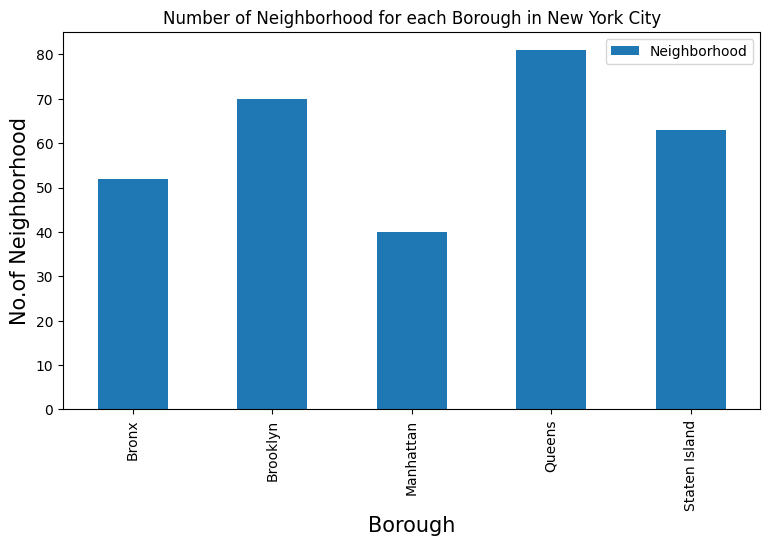

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### From the above Bar Plot, we can see that Queens has highest number of neighborhoods.

Next we will collect Chinese resturants for each Neighborhood.

In [16]:
# prepare neighborhood list that contains Chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_resturants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Chinese Resturants in '+Neighborhood+', '+Borough+':'+str(len(chinese_resturants)))
    for resturant_detail in chinese_resturants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Resturants in Wakefield, Bronx:1
( 2 / 306 ) Chinese Resturants in Co-op City, Bronx:2
( 3 / 306 ) Chinese Resturants in Eastchester, Bronx:0
( 4 / 306 ) Chinese Resturants in Fieldston, Bronx:2
( 5 / 306 ) Chinese Resturants in Riverdale, Bronx:0
( 6 / 306 ) Chinese Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Chinese Resturants in Marble Hill, Manhattan:1
( 8 / 306 ) Chinese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Chinese Resturants in Norwood, Bronx:2
( 10 / 306 ) Chinese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Chinese Resturants in Baychester, Bronx:3
( 12 / 306 ) Chinese Resturants in Pelham Parkway, Bronx:4
( 13 / 306 ) Chinese Resturants in City Island, Bronx:1
( 14 / 306 ) Chinese Resturants in Bedford Park, Bronx:2
( 15 / 306 ) Chinese Resturants in University Heights, Bronx:1
( 16 / 306 ) Chinese Resturants in Morris Heights, Bronx:1
( 17 / 306 ) Chinese Resturants in Fordham, Bronx:1
( 18 / 306 ) Chinese Resturants in East Tremont, Bronx:

( 141 / 306 ) Chinese Resturants in Sunnyside, Queens:3
( 142 / 306 ) Chinese Resturants in East Elmhurst, Queens:0
( 143 / 306 ) Chinese Resturants in Maspeth, Queens:1
( 144 / 306 ) Chinese Resturants in Ridgewood, Queens:2
( 145 / 306 ) Chinese Resturants in Glendale, Queens:1
( 146 / 306 ) Chinese Resturants in Rego Park, Queens:2
( 147 / 306 ) Chinese Resturants in Woodhaven, Queens:3
( 148 / 306 ) Chinese Resturants in Ozone Park, Queens:2
( 149 / 306 ) Chinese Resturants in South Ozone Park, Queens:4
( 150 / 306 ) Chinese Resturants in College Point, Queens:2
( 151 / 306 ) Chinese Resturants in Whitestone, Queens:2
( 152 / 306 ) Chinese Resturants in Bayside, Queens:2
( 153 / 306 ) Chinese Resturants in Auburndale, Queens:2
( 154 / 306 ) Chinese Resturants in Little Neck, Queens:5
( 155 / 306 ) Chinese Resturants in Douglaston, Queens:4
( 156 / 306 ) Chinese Resturants in Glen Oaks, Queens:0
( 157 / 306 ) Chinese Resturants in Bellerose, Queens:1
( 158 / 306 ) Chinese Resturants

KeyError: 'groups'

In [17]:
chinese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4edbac4e775bcc53fc0ed5f8,Hong Kong China King
1,Bronx,Co-op City,4e4df7abbd4101d0d79f476b,China Top
2,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet
3,Bronx,Fieldston,4cc4d337be40a35d390b814c,Lee's Chinese Kitchen
4,Bronx,Fieldston,4f5543a7e4b0ac8e5378b9de,Broadway Chinese Kitchen


In [18]:
chinese_rest_ny.shape

(333, 4)

### From the above result, we see that there are 410 Chinese Resturants across New York City.

Now let create a BAR PLOT to show Number of Chinese Resturants for each Borough in New York City.

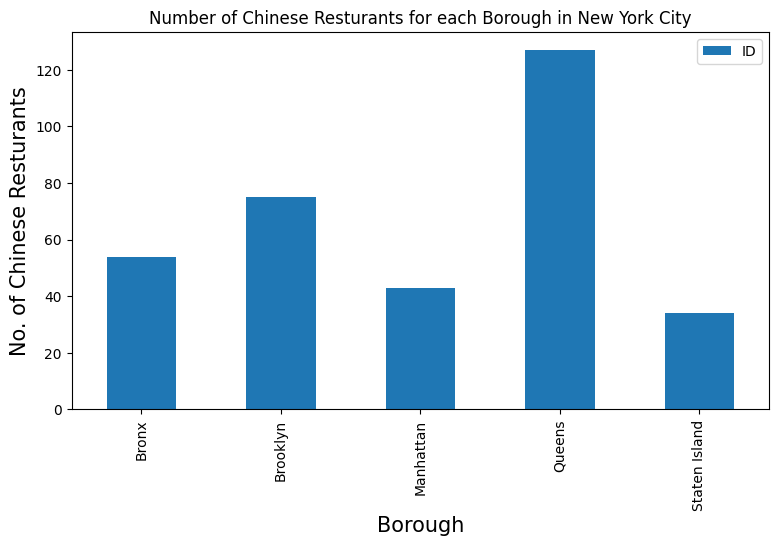

In [19]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chinese Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No. of Chinese Resturants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### From the above Bar Plot, we can see that Queens has highest number of Chinese resturants.

Now let create a BAR PLOT to show Number of Chinese Resturants for each Neighborhood in New York City.

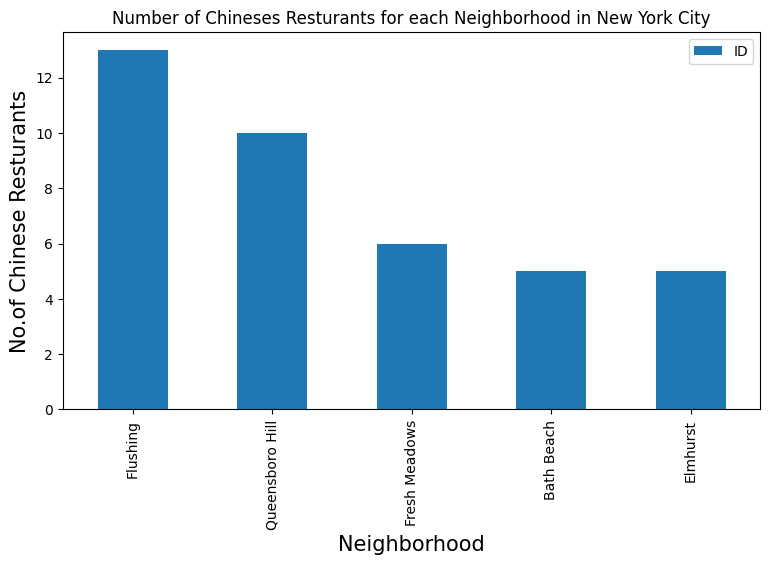

In [20]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Chineses Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Chinese Resturants', fontsize=15)
#giving a bar plot
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [21]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Flushing']

,Borough,Neighborhood,ID,Name
182,Queens,Flushing,5747a89b498ee4b7a5106556,DunHuang Lanzhou Beef Noodle
183,Queens,Flushing,52235ea211d2fe55782d764c,Dong Yi Feng
184,Queens,Flushing,4ad50f59f964a520950121e3,Fu Run 賦潤東北美食
185,Queens,Flushing,4c78756397028cfaec16d8fe,New Golden Szechuan Chinese Restaurant
186,Queens,Flushing,4fa3f81be4b0a34ac673bf1e,Taipei Hong 台北夯
187,Queens,Flushing,4faff7eae4b03b8055801cde,Xi'an Famous Foods
188,Queens,Flushing,4d1bcddc1356224bc6410abe,OK Ryan
189,Queens,Flushing,4ac38216f964a520929b20e3,Golden Shopping Mall
190,Queens,Flushing,4ef37491d3e32dc398c7c5c7,Laoma Mala Tang
191,Queens,Flushing,4a1845c8f964a52092791fe3,Asian Jewels Seafood Restaurant 敦城海鲜酒家


### We can see that, Flushing in Queens has the highest number of Chinese Resturants with a total count of 14.

### Now we will get the ranking of all 330 resturants for further analysis.

In [22]:
# prepare neighborhood list that contains chinese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4edbac4e775bcc53fc0ed5f8
( 1 / 333 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e4df7abbd4101d0d79f476b
( 2 / 333 ) processed
                         ID            Name  Likes  Rating  Tips
0  4c66dcfaaebea593955a74d0  Chinese Buffet      7     5.0    10
( 3 / 333 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4cc4d337be40a35d390b814c
( 4 / 333 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4f5543a7e4b0ac8e5378b9de
( 5 / 333 ) processed
                         ID                           Name  Likes  Rating  \
0  4d965fd061a3a1cde4989a42  Lucky Star Chinese Restaurant      3     7.4   

   Tips  
0     5  
( 6 / 333 ) processed
                         ID                            Name  Likes  Rating  \
0  4e2e080218

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4edbac4e775bcc53fc0ed5f8
( 55 / 333 ) processed
                         ID                 Name  Likes  Rating  Tips
0  4b1c3b4cf964a520bb0424e3  Grand Sichuan House     37     8.3    24
( 56 / 333 ) processed
                         ID Name  Likes  Rating  Tips
0  5553702c498ecb85f99d8f37  XIN      6     7.2     4
( 57 / 333 ) processed
                         ID        Name  Likes  Rating  Tips
0  4a5beec3f964a52006bc1fe3  86 Noodles     19     7.3    22
( 58 / 333 ) processed
                         ID         Name  Likes  Rating  Tips
0  4c65da95f7a80f47b6959c7a  Spicy Bampa     28     7.5    10
( 59 / 333 ) processed
                         ID            Name  Likes  Rating  Tips
0  574a1a53498e6a1b7cb336cb  Orchid Dynasty      6     7.4     1
( 60 / 333 ) processed
                         ID       Name  Likes  Rating  Tips
0  4bdcc1043904a593ba9e4f9e  New Ruans      8     7.1     2


                         ID                              Name  Likes  Rating  \
0  4d8151697c956dcb09cff27b  New Jin Shing Chinese Restuarant      6     7.2   

   Tips  
0     4  
( 110 / 333 ) processed
                         ID            Name  Likes  Rating  Tips
0  4cd4dd3e67adf04d8b102a91  Lee Good Taste      5     6.8     4
( 111 / 333 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e4cde0cbd413c4cc66cceeb
( 112 / 333 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4bd4ef1f6f649521c0726eec
( 113 / 333 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c631a96edd320a15495ae29
( 114 / 333 ) processed
                         ID                           Name  Likes  Rating  \
0  4bfafc771134b713e48c0fc9  Green Lake Chinese Restaurant      5     7.6   

   Tips  
0     5  
( 115 / 333 ) processed
                

                         ID     Name  Likes  Rating  Tips
0  59ac42570868a23a1e0fde8f  Red Hot     10     8.4     1
( 163 / 333 ) processed
                         ID                     Name  Likes  Rating  Tips
0  58fbdc8fe0755067a6dcf3ee  108 Food- Dried Hot Pot     39     7.9    12
( 164 / 333 ) processed
                         ID       Name  Likes  Rating  Tips
0  5b4a97c16adbf5002ce288c2  Dun Huang      8     7.4     2
( 165 / 333 ) processed
                         ID           Name  Likes  Rating  Tips
0  5c990a8886f4cc002cf19bc1  Thy’s Noodles     20     8.1     7
( 166 / 333 ) processed
                         ID         Name  Likes  Rating  Tips
0  52169fba11d21db81bdab2a0  Han Dynasty   1152     8.9   347
( 167 / 333 ) processed
                         ID                Name  Likes  Rating  Tips
0  4ae1d8b2f964a520e78721e3  Peking BBQ Chicken     47     8.3    26
( 168 / 333 ) processed
                         ID                                Name  Likes  \
0  5a466

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4bb674486edc76b0ecf8301c
( 216 / 333 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4f628efbe4b03be1015fa338
( 217 / 333 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4ce842849f776ea8190b5d22  Chow Chinese Take Out      5     7.5     5
( 218 / 333 ) processed
                         ID         Name  Likes  Rating  Tips
0  4b78929ff964a520aad72ee3  Bell Garden      1     6.8     6
( 219 / 333 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4ce842849f776ea8190b5d22  Chow Chinese Take Out      5     7.5     5
( 220 / 333 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c1b9e9463750f47c524b567
( 221 / 333 ) processed
                         ID                 Name  Likes  Rating  Tips
0  53794fd211d282a3c

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4e4dfb24bd4101d0d79f8cf5
( 271 / 333 ) processed
                         ID           Name  Likes  Rating  Tips
0  4ce49482e571a09332bc8587  Sagar Chinese     17     6.9    15
( 272 / 333 ) processed
                         ID               Name  Likes  Rating  Tips
0  4b54a474f964a5205ac427e3  Foo On Restaurant      4     5.9     6
( 273 / 333 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4b7f10f5f964a520001430e3
( 274 / 333 ) processed
                         ID                                Name  Likes  \
0  4ac90140f964a520f7bd20e3  Main Street Taiwanese Gourmet 北港台菜     63   

   Rating  Tips  
0     7.5    28  
( 275 / 333 ) processed
                         ID                        Name  Likes  Rating  Tips
0  50e9c4b1e4b0541e6c67a2ab  Hly Chinese Cuisine (三人百姓)     12     8.2     7
( 276 / 333 ) processed
                 

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4cb510469c7ba35db1088806
( 324 / 333 ) processed
                         ID          Name  Likes  Rating  Tips
0  4c14210c7f7f2d7fae69e068  Crown Palace      9     5.8     5
( 325 / 333 ) processed
                         ID                              Name  Likes  Rating  \
0  4b747adcf964a52010df2de3  Lucky Fortune Chinese Restaurant      7     6.6   

   Tips  
0     6  
( 326 / 333 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4bddca41ffdec928876ee6a1
( 327 / 333 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4c2bd58f57a9c9b6f591f667
( 328 / 333 ) processed
                         ID    Name  Likes  Rating  Tips
0  4c924bf52626a1cdf368396b  Ho Wok      4     5.8     1
( 329 / 333 ) processed
                         ID         Name  Likes  Rating  Tips
0  5165e9fee4b08d48

Now that we have got all the chinese resturants in new york city , we will analyze it.

In [23]:
chinese_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,0,0,0,0,0
1,Bronx,Co-op City,0,0,0,0,0
2,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet,7,5,10
3,Bronx,Fieldston,0,0,0,0,0
4,Bronx,Fieldston,0,0,0,0,0


In [24]:
chinese_rest_stats_ny.shape

(333, 7)

In [25]:
chinese_rest_ny.shape

(333, 4)

Now that we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required.

In [26]:
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file.

In [27]:
chinese_rest_stats_ny_csv=pd.read_csv('chinese_rest_stats_ny.csv')

In [28]:
chinese_rest_stats_ny_csv.shape

(333, 7)

In [29]:
chinese_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,0,0,0,0.0,0
1,Bronx,Co-op City,0,0,0,0.0,0
2,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet,7,5.0,10
3,Bronx,Fieldston,0,0,0,0.0,0
4,Bronx,Fieldston,0,0,0,0.0,0


In [30]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 7 columns):
Borough         333 non-null object
Neighborhood    333 non-null object
ID              333 non-null object
Name            333 non-null object
Likes           333 non-null object
Rating          333 non-null object
Tips            333 non-null object
dtypes: object(7)
memory usage: 18.3+ KB


The Data type of 'Likes' and 'Tips' are of type 'String'. we will convert them into type 'Float' for further analysis.

In [31]:
chinese_rest_stats_ny['Likes']=chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips']=chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny['Rating']=chinese_rest_stats_ny['Rating'].astype('float64')

In [32]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 7 columns):
Borough         333 non-null object
Neighborhood    333 non-null object
ID              333 non-null object
Name            333 non-null object
Likes           333 non-null float64
Rating          333 non-null float64
Tips            333 non-null float64
dtypes: float64(3), object(4)
memory usage: 18.3+ KB


Now we will find the Indian restuarants with Maximum Likes, Maximum Ratings and Maximum Tips.

In [33]:
# Resturant with maximum Likes
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1488
Rating                               8.8
Tips                                 521
Name: 148, dtype: object

In [34]:
# Resturant with maximum Rating
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood             Lower East Side
ID              5b380f649deb7d00399fdf9d
Name               Kings County Imperial
Likes                                 67
Rating                               9.2
Tips                                  10
Name: 151, dtype: object

In [35]:
# Resturant with maximum Tips
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                               1488
Rating                               8.8
Tips                                 521
Name: 148, dtype: object

Next lets visualize neighborhood with maximum average rating of resturants.

In [36]:
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [37]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
64,Greenpoint,9.00
104,North Side,8.90
88,Marine Park,8.90
83,Lower East Side,8.85
66,Greenwich Village,8.80
23,Chelsea,8.80
98,Murray Hill,8.80
42,East Village,8.70
101,Noho,8.70
149,Upper West Side,8.60


### Above are the top neighborhoods with top average rating of Chinese resturants.

Similarly we will find the average rating of Chinese Resturants for each Borough.

In [38]:
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [39]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.125581
1,Brooklyn,5.045333
3,Queens,4.515748
4,Staten Island,3.452941
0,Bronx,1.718519


Let's visualise it

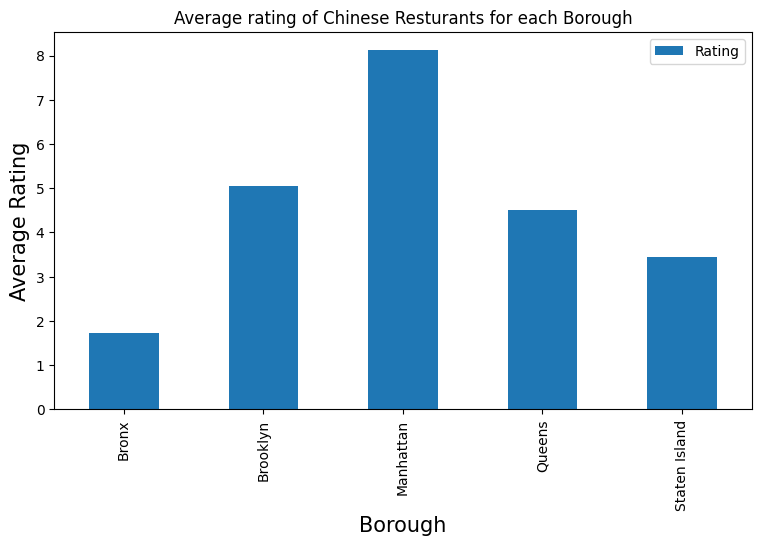

In [40]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Chinese Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 8.0 to visualize on map.

In [41]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [42]:
ny_neighborhood_stats.head()

,Neighborhood,Average Rating
23,Chelsea,8.8
24,Chinatown,8.3
36,Dongan Hills,8.1
38,Downtown,8.3
42,East Village,8.7


In [43]:
ny_neighborhood_stats.shape

(22, 2)

We will join this dataset to original new york data to get lonitude and latitude.

In [44]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [45]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [46]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chelsea,40.744035,-74.003116,8.800
1,Staten Island,Chelsea,40.594726,-74.189560,8.800
2,Manhattan,Chinatown,40.715618,-73.994279,8.300
3,Staten Island,Dongan Hills,40.588673,-74.096399,8.100
4,Brooklyn,Downtown,40.690844,-73.983463,8.300
5,Manhattan,East Village,40.727847,-73.982226,8.700
6,Manhattan,Gramercy,40.737210,-73.981376,8.500
7,Brooklyn,Greenpoint,40.730201,-73.954241,9.000
8,Manhattan,Greenwich Village,40.726933,-73.999914,8.800
9,Manhattan,Little Italy,40.719324,-73.997305,8.300


Finally, Let's show this data on a map.

In [47]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [48]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose.

In [49]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [50]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods. Lets Visualize Boroughs based on average Rating.

In [51]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'

map = ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')